# Application of the simple shooting method

* Author: Olivier Cots
* Date: March 2021

------

## The energy min 2D integrator problem with friction and transversality conditions

Consider the following optimal control problem (Lagrange cost, fixed final time):

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \frac{1}{2} \int_0^{1} u^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = (x_2(t), -\mu x_2^2(t) + u(t)), \quad  u(t) \in \mathrm{R}, \quad t \in [0, 1] \text{ a.e.},    \\[1.0em]
        x(0) = (-1, 0), \quad c(x(1)) = 0.
    \end{array}
    \right. 
$$

We will consider two cases:

$$
a)~ c(x) = x - (1, 0), \quad b)~ c(x) = x_1 - 1.
$$

We consider the normal case ($p^0 = -1$), so the pseudo-Hamiltonian of the problem is

$$
    H(x,p,u) = p_1 x_2 + p_2 (-\mu x_2^2 + u) - \frac{1}{2} u^2.
$$

We denote by $t_0$, $t_f$ and $x_0$ the initial time, final time and initial condition.


<div class="alert alert-warning">

**Goal**

Solve the cases a) and b) of this optimal control problem by simple shooting with the nutopy package.
    
</div>

**_Remark._** 
* See this [page](https://ct.gitlabpages.inria.fr/gallery/shooting_tutorials/simple_shooting_general.html) for a general presentation of the simple shooting method with the use of nutopy package. 
* See this [page](https://ct.gitlabpages.inria.fr/gallery/smooth_case/smooth_case.html) for a more detailed use of nutopy package on a smooth example. 
* See this [page](https://ct.gitlabpages.inria.fr/nutopy/) for the documention of nutopy package.

## Preliminaries

In [1]:
# import packages
import nutopy as nt
import nutopy.tools as tools
import nutopy.ocp as ocp
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 150

In [2]:
# parameters
t0          = 0.0                    # initial time
tf          = 1.0                    # final time
x0          = np.array([-1.0, 0.0])  # initial condition
xf_target_a = np.array([1.0, 0.0])   # final target for the case a
xf_target_b = np.array([1.0])        # final target for the case b
mu          = 0.5                    # parameter mu

## Questions

<div class="alert alert-info">

**_Question 1:_**
    
Write the maximizing control in feeback form $u[p]$.
      
</div>

**Answer 1:** \
 The maximization condition:
 $$
 H(t) = max_{w \in R} H(x(t), p(t), w)
 $$
 is equivalent here to the condition
 $$
 \nabla_{u} H(t) = 0
 $$
 so 
 $$
u[p] = p_2
 $$

<div class="alert alert-info">

**_Question 2:_**
    
Complete the code of `ufun` coding the control in feedback form.
      
</div>

In [3]:
# ----------------------------
# Answer 2 to complete here
# ----------------------------
#
# Control in feedback form: used for plotting
#
@tools.vectorize(vvars=(1,))
def ufun(p):
    u = p[1]
    return u

<div class="alert alert-info">

**_Question 3:_**
    
Write the maximized Hamiltonian and the adjoint equation.
    
</div>

**Answer 3:** \
$$
h(x, p) = H(x, p, u[p]) = p_1 x_2 - \mu p_2 x_2^{2} + \frac{1}{2} p_2^{2}
$$
The PMP gives 
$$
\dot{x}(t) = \nabla_{p} H(t)
$$

$$
\dot{p}(t) = - \nabla_{x} H(t)
$$

<div class="alert alert-info">

**_Question 4:_**
    
Complete the code of `hfun` and `dhfun` coding the maximized Hamiltonian and its derivative.
      
</div>

**_Remark._** Let us denote by $h(t, x, p) = H(x, p, u[p])$ the maximized Hamiltonian. The function `dhfun` codes:

$$
    \frac{\partial h}{\partial x}(t, x, p) \cdot \delta x + \frac{\partial h}{\partial p}(t, x, p) \cdot \delta p.
$$

The (normal and maximized) Hamiltonian is straightforwardly implemented in `hfun`. For further needs, we have to implement its first and second derivatives _wrt._ to state ($x$) and costate ($p$). This derivatives, evaluated against first and second order increments are implemented by `dhfun` and `d2hfun`, respectively.

In [4]:
# ----------------------------
# Answer 4 to complete here
# ----------------------------
#
# Maximized Hamiltonian with its derivative
#
def hfun(t, x, p):
    '''
        Hamiltonian: 
        
            h = hfun(t, x, p, mu)
    
        Inputs: 
        
            - t  : time, float
            - x  : state, array
            - p  : co-state, array
            - mu : friction parameter, float
            
        Outputs:
        
            - h  : Hamiltonian, float
        
    '''
    x2 = x[1]
    p1 = p[0]
    p2 = p[1]
    h  = p1*x2-mu*x2**2*p2+0.5*p2**2  
    return h

def dhfun(t, x, dx, p, dp):
    '''
        Derivative of the Hamiltonian: 
        
            hd = dhfun(t, x, dx, p, dp, mu)
    
        Inputs: 
        
            - t  : time, float
            - x  : state, array
            - dx : state increment, array
            - p  : co-state, array
            - dp : co-state increment, array
            - mu : friction parameter, float
            
        Outputs:
        
            - hd : derivative of the Hamiltonian, float
        
    '''
    x2  = x[1]
    dx2 = dx[1]
    p1  = p[0]
    p2  = p[1]
    dp1 = dp[0]
    dp2 = dp[1]
    hd  = dp1*x2+p1*dx2-2.0*mu*x2*dx2*p2-mu*x2**2*dp2+p2*dp2
    return hd

In [5]:
# The second order derivative of hfun and the definition of the flow
#
def d2hfun(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    x2   = x[1]
    dx2  = dx[1]
    d2x2 = d2x[1]
    p1   = p[0]
    p2   = p[1]
    dp1  = dp[0]
    dp2  = dp[1]
    d2p1 = d2p[0]
    d2p2 = d2p[1]
    hdd  =    dp1*d2x2 \
            + d2p1*dx2 \
            - 2.0*mu*d2x2*dx2*p2 - 2.0*mu*x2*dx2*d2p2 \
            - 2.0*mu*x2*d2x2*dp2 \
            + d2p2*dp2
    return hdd

hfun = nt.tools.tensorize(dhfun, d2hfun, tvars=(2, 3))(hfun)

In [6]:
h    = ocp.Hamiltonian(hfun)   # The Hamiltonian object

To define in the following the shooting function, one must integrate the Hamiltonian system defined by `h`. This is done by defining a [Flow](https://ct.gitlabpages.inria.fr/nutopy/api/ocp.html#nutopy.ocp.Flow) object:

In [7]:
f    = ocp.Flow(h)             # The flow associated to the Hamiltonian object is 
                               # the exponential mapping with its derivative
                               # that can be used to define the Jacobian of the 
                               # shooting function

To compute the value of the Hamiltonan flow at time $t_f$ starting from time $t_0$ and initial conditions $(x_0,p_0)$, do the following:

In [8]:
p0 = np.array([0.1, 0.1])
xf, pf = f(t0, x0, p0, tf)
print(xf, pf)

[-0.96666508  0.05000781] [0.1        0.00127897]


### case a: $c(x) = x - x_f$

In this case, the shooting function is simply given by

$$
    S(p_0) = \pi_x(z(t_f, t_0, x_0, p_0)) - x_f,
$$

where $x_f = (1, 0)$ and $z(t_f, t_0, x_0, p_0)$ is the value of the Hamiltonan flow at time $t_f$ starting from time $t_0$ and initial conditions $(x_0,p_0)$. 

<div class="alert alert-info">

**_Question 5:_**
    
Complete the code of `shoot` coding the shooting function.
      
</div>

In [9]:
# ----------------------------
# Answer 5 to complete here
# ----------------------------
#
# Shooting function and its derivative
#
# Nota bene: use f, t0, x0, tf, xf_target_a
#

def shoot(p0):
    '''
        Shooting function
        
            s = S(p0)
            
        Inputs:
        
            p0 : initial co-state, array
            
        Outputs:
        
            s  : value of the shooting function, array
    '''
    xf, pf = f(t0, x0, p0, tf)
    s = xf - xf_target_a 
    return s

The Jacobian of $S$ at $p_0$ against the vector $\delta p_0$ is given by:

$$
    S'(p_0) \cdot \delta p_0 = \pi_x \left(\frac{\partial z}{\partial p_0}(t_f, t_0, x_0, p_0) \cdot \delta p_0 \right) = 
    \frac{\partial x}{\partial p_0}(t_f, t_0, x_0, p_0) \cdot \delta p_0.
$$

In [10]:
# Jacobian of the shooting function against dp0
def dshoot(p0, dp0):
    (xf, dxf), _ = f(t0, x0, (p0, dp0), tf)
    ds = dxf
    return ds

# We tensorize the shooting function, otherwise, we would have to give the Jacobian 
# of S instead of the Jacobian against a vector, to the nle solver.
shoot = nt.tools.tensorize(dshoot)(shoot)

In [11]:
# Resolution of the shooting function
#
p0_guess = np.array([0.1, 0.1])
sol = nt.nle.solve(shoot, p0_guess, df=shoot); p0_sol = sol.x
print('p0_sol =', p0_sol, '\t shoot =', shoot(p0_sol))


     Calls  |f(x)|                 |x|
 
         1  1.967300768937284e+00  1.414213562373095e-01
         2  1.719731572785058e+00  1.798534093044435e+01
         3  1.410906422430162e+00  3.487107124079319e+01
         4  1.991207495319201e+00  3.937341638076401e+01
         5  7.277880985716003e-01  3.625515294040529e+01
         6  4.725619938021236e-01  3.555941926121005e+01
         7  3.166103150680820e-02  3.433969876028567e+01
         8  2.245063172737618e-03  3.442461252396227e+01
         9  6.943644107636048e-04  3.442864514091168e+01
        10  1.078577109838329e-04  3.442751328490402e+01
        11  2.201216851276362e-07  3.442730460220396e+01
        12  2.084482725336880e-09  3.442730418046801e+01
        13  1.938850712358454e-11  3.442730418446996e+01

 Results of the nle solver method:

 xsol    =  [31.89425568 12.96131661]
 f(xsol) =  [4.31077396e-12 1.89032123e-11]
 nfev    =  13
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative er

In [12]:
# Function to plot the solution
def plotSolution(p0):

    N      = 100
    tspan  = list(np.linspace(t0, tf, N+1))
    xf, pf = f(t0, x0, p0, tspan)
    u      = ufun(pf)

    fig = plt.figure()
    ax  = fig.add_subplot(711); ax.plot(tspan, xf); ax.set_xlabel('t'); ax.set_ylabel('$x$'); ax.axhline(0, color='k')
    ax  = fig.add_subplot(713); ax.plot(tspan, pf); ax.set_xlabel('t'); ax.set_ylabel('$p$'); ax.axhline(0, color='k')
    ax  = fig.add_subplot(715); ax.plot(tspan,  u); ax.set_xlabel('t'); ax.set_ylabel('$u$'); ax.axhline(0, color='k')
    
    x1  = np.zeros(N+1)
    x2  = np.zeros(N+1)
    for i in range(0, N+1):
        x1[i] = xf[i][0]
        x2[i] = xf[i][1]
    
    ax  = fig.add_subplot(717); ax.plot(x1,  x2); ax.set_xlabel('x1'); ax.set_ylabel('$x2$'); ax.axhline(0, color='k')

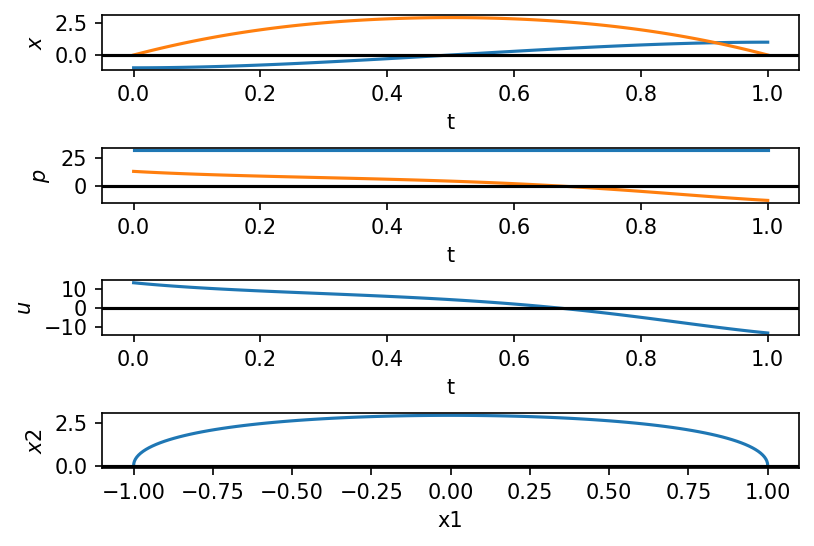

In [13]:
# Plot solution
plotSolution(p0_sol)

### case b: $c(x) = x_1 - 1$

<div class="alert alert-info">

**_Question 6:_**
    
Give the transversality condition.
      
</div>

**Answer 6:** \
transversality condition : 
$$
p(t_f) = J_{c}^{T}(x(t_f)) [\lambda;  \beta] = (\lambda, 0)
$$

<div class="alert alert-info">

**_Question 7:_**
    
Write the shooting function.
      
</div>

**Answer 7:** \
shooting function
$$
s(p_0, \lambda) = 
$$

<div class="alert alert-info">

**_Question 8:_**
    
Solve the shooting equations.
      
</div>

In [14]:
# ----------------------------
# Answer 8 to complete here
# ----------------------------
#
# Write the shooting function and its derivative
# Write the call to the nle solver
# Plot the solution
#
# Nota bene: use f, t0, x0, tf, xf_target_b
#